# **Graph Ordering Attention Network**

## 1. Introduction and Problem Formulation
A Graph Neural Network is a machine learning model designed to operate on graph-structured data.

We denote a graph with $G=(V,E)$ where 

$$
V=\{v_1,...,v_N\}\quad\text{and}\quad E\subseteq\{(v_i,v_j)\mid (v_i,v_j)\in V^2\text{ and }v_i\neq v_j\}
$$

are respectively the set of nodes and edges of the graph.

We also denote with $A\in\mathbb{R}^{n\times n}$ the **adjacency matrix** of $G$ and with

$$
X=[x_1,...,x_n]^T\in\mathbb{R}^{N\times d_I}\quad\text{and}\quad Y = [y_i,...,y_N]^T\in\mathbb{N}^N
$$

respectively the **node features** and the **label vector**.

Finally we denote with 
$$
\mathcal{N}(u) = \{v\mid (v,u)\in E\}\quad\text{and}\quad\overline{\mathcal{N}}(u) = \mathcal{N}\cup u
$$
 the **neighborhood** of a node $u$ and the neighborhood including the node itself, and with
 $$
X_{\overline{\mathcal{N}}(u)}
 $$
 the **features** of the node $u$.

A GNN exploit the graph structure $A$ and node features $X$ to learn an hidden representation $h_u$ of each node $u$ such that the label $y_u$ can be predicted from $h_u$.
<br><br>

## 2. Message Passing and Properties of the Aggregator
To exploit the graph structure represented by the adjacency matrix $A$, usually GNNs models use a **neighborhood message passing** scheme, in which every node updates its representation aggregating the ones of its neighbors and combining them with its previous representation. 
It's important though that the aggregation function satisfy some important properties:
- It has to be **permutation-invariant**, which means that given a function $f(\cdot)$ and a set of $M$ elements, we have
$$
f(\{x_1,...,x_M\}) = f(\{x_{\pi(1)},...,x_{\pi(M)}\}\quad\forall \pi\in S_M
$$
Where $\pi$ is a permutation and $S_M$ is the set of all permutations of $M$ elements.
Having the aggregation function permutation-invariant ensures that the GNN layer is **permutation-equivariant**, which means that
$$
\pi f(\{x_1,...,x_M\}) = f(\{x_{\pi(1)},...,x_{\pi(M)}\}\quad\forall \pi\in S_M
$$
which guarantees that the layer does not depend on the order of the rows and columns of the adjacency matrix $A$.

- It has to be **injective**, which means that the representation of a node $v$ with a neighbor $\mathcal{N}(v)$ should be different than the one of the same node with a neghibor $\mathcal{N}'(v)$ if $\mathcal{N}(v)\neq\mathcal{N}'(v)$.

- It should employ **relational reasoning**, which means that the label of a node may not only depend on the information of its neighbors but also on their interactions. We call these informations **synergistic information**.
<br><br>

## 3. Partial Information Decomposition (PID)
Information theory provides a tool for measuring the neighborood influence: the **partial information decomposition**.<br>
Given a node $u\in V$, if we denote with $H_{\overline{\mathcal{N}}(u)}=[h_{v_1},...,h_{v_{\overline{\mathcal{N}}(u)}}]\in\mathbb{R}^{|\overline{\mathcal{N}}(u)|\times d}$ and $h_u$ respectively the hidden representation of the nodes in $\overline{\mathcal{N}}(u)$ and of node $u$, and assume that $H_{\overline{\mathcal{N}}(u)}$ and $h_u$ have distribution $p(H_{\overline{\mathcal{N}}(u)})$ and $p(h_u)$, then the **mutual information** between $h_u$ and $H_{\overline{\mathcal{N}}(u)}$ is defined as


$$
I(h_u, H_{\overline{\mathcal{N}}(u)}) = \int\int p\left(h_u, H_{\overline{\mathcal{N}}(u)}\right)\log\left(\frac{p\left(h_u, H_{\overline{\mathcal{N}}(u)}\right)}{p(h_u)p\left(H_{\overline{\mathcal{N}}(u)}\right)}\right)dh_udH_{\overline{\mathcal{N}}(u)}
$$
which can be decomposed (Williams and Beer [2010]) into three parts:
$$
I(h_u, H_{\overline{\mathcal{N}}(u)}) = \sum_{v\in\overline{\mathcal{N}}(u)}U_v + R + S
$$
where
- $U_v$ is the **unique information** of each node $v\in \overline{\mathcal{N}}(u)$, that is the information only that node carries;
- $R$ is the **redundant information** which is the information that overlaps in two or more neighbors;
- $S$ is the **synergistic information** which is the information we can capture only taking into account the interactions among the neighbors.


Assuming a MPNN model, we denote the information that a node $u$ receives from a neighbor node $v$ as $c_{uv}\in\mathbb{R}^d$, which represents the contribution of $v$ to the state of $u$. 
We can express the aggregated messages as
$$
m_u = \sum_{v\in\mathcal{N}(u)}c_{uv}
$$
The value of $c_{uv}$ can be a function of $S_{uv}$ and $h_v$ such as $c_{uv} = S_{uv}h_v$ (used for the Graph Convolutiaonal Networks [Kipf and Weiling, 2017]), where $S$ is a graph shift operator (it could be simply $A$, but $(D+I)^{-1/2}(A+I)(D+I)^{-1/2}$ with $D$ the graph's degree matrix, has been found to be very effective), or also a function of $h_u$ and $h_v$, such as $c_{uv}=a_{uv}h_v$ (used for the Graph Attention Network [Veličković et al., 2018]), where $a_{uv}$ is the attention score between $h_u$ and $h_v$.

The problem with the previous methods is that they process each neighbor information individually, ignoring any interaction between neighbors therefore are not able to capture the synergistic information.<br>
To address this problem we can define $c_{uv}$ as a function not only of $h_u$ and $h_v$ but also of $h_j$, for $j\in\mathcal{N}(u)$, i.e.
$$
c_{uv} = f(S, H_{\overline{\mathcal{N}}(u)})
$$

## 4. Graph Ordering Attention Layer
The architecture of a GOAT layer consists of **two parts**:
  1. The **Ordering part**, which transforms the unordered multiset of the neighbor's hidden state vector, of dimension $d$, $\{h_1,...,h_P\}$, with $P=|\overline{\mathcal{N}}(u)|$, into an ordered sequence, using **attention**.<br>
  Similiarly to the GAT, for each node $v_i\in V$, we first apply a shared linear transformation using a weight matrix $W\in\mathbb{R}^{d\times d}$ and then a shared self-attention mechanism parametrized by $a\in R^{2d}$, therefore the attention scores are computed by:
  $$
  \tag{4.1}
  a_{ij} = LeakyReLU\left(a^T[Wh_1\parallel Wh_j]\right)\quad\forall j\,\text{ s.t. }\,v_j\in\overline{\mathcal{N}}(v_i)
  $$
  Then we sort the coefficients in decreasing order of magnitude, and if two neighbors have the same attention score we compare their hidden state vector's elements to ensure the sorting function is **deterministic** and **permutation invariant**.<br>
  Obtained a permutation $\pi$, we construct the sorted sequence of the neighbor's hidden states normalized using a **softmax** function:
  $$
  \tag{4.2}
  h_{sorted(i)} = \left[\frac{\exp\left(a_{i\pi(1)}\right)}{\sum_{j=1}^Q\exp\left(a_{i\pi(j)}\right)}Wh_{\pi(1)},...,\frac{\exp\left(a_{i\pi(Q)}\right)}{\sum_{j=1}^Q\exp\left(a_{i\pi(j)}\right)}Wh_{\pi(Q)}\right]
  $$

  2. The **Sequence Modeling part**, which takes the ordered sequences produced in the ordering part as input and processes them using a RNN, shared across all neighborhoods, to generate the new states.<br>
For the PID, a **Bidirectional LSTM** seems to be the best choice [Hochreiter and Schmidhuber, 1997] (but we could use any RNN):
$$
  \tag{4.3}
  h_i^{new} = LSTM\left(h_{sorted(i)}\right)\in \mathbb{R}^{d_O}
$$
The Bidirectional LSTM ensures that both the nodes preceding and succeeding a node $j$ are taken into account when calculating the contribution $c_{ij}$.<br>
To have a faster and scalable implementation we **pad** all the neighborhood sequences with zero vectors to make them equal in length to the sequence of hidden states of the largest neighborhood in the graph. This allows us to train the LSTM on larger batches of neighborhoods in parallel (alternatively we can maintain different lenghts and feed the LSTM with one sequence at a time, but it's slower).<br>

We could also use a **multi-head attention ordering** to provide additional representational power, infact if only one sensible ordering of the nodes in a neighborhood exists, this could help estimating it more robustly, if not it allows to take all of them into account.<br>
If $K$ is the number of attention heads, we have
$$
\tag{4.4}
a_{ij}^k = a^k\left(W^kh_i, W^kh_j\right)
$$
Then we sort them obtaining multiple orderings of the neighborhood $h^k_{sorted(i)}$ for $k\in\{1,...,K\}$ and to generate the final representation we concatenate the features from the $K$ independent Bidirectional LSTM models:
$$
\tag{4.5}
h_i^{new} = LSTM^1\left(h^1_{sorted(i)}\right)\parallel\cdots\parallel LSTM^k\left(h^k_{sorted(i)}\right)
$$
If we are using Multi-Attention on the last layer of the network, instead of concatenating the LSTMs outputs we **average** them and apply an activation function (softmax for example).

## 5. Implementation
Now we are gonna write an implementation of a GNN that adopt a GOAT layer. The paper suggested to use it in combination with GAT or GCN as final layer, that averages the results of the attention heads instead of concatenating them:

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn
import numpy as np

In [9]:
def format_pytorch_version(version):
    return version.split('+')[0]

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html --quiet
import torch_geometric as pygeom

In [10]:
class GOAT(nn.Module):
  def __init__(self, inputs, outputs, outputsLSTM, dropout, alpha):
    super(GOAT, self).__init__()
    self.inputs = inputs
    self.outputs = outputs
    self.outputsLSTM = outputsLSTM
    self.dropout = nn.Dropout(p=dropout) # Dropout was used in the original paper in different spots, to avoid overfitting
    self.alpha = alpha 

    self.linear = nn.Linear(self.inputs, self.outputs, bias=False) # As mentioned in the paper of the GAT, a linear transformation is necessary to obtain enough expressive power (basically that's W in equation 4.1) 
    self.attention_source = nn.Parameter(torch.Tensor(1, outputs)) # As we will see later, for a faster implementation we adopt the method used in the paper implementation which calculates the attention scores only for the relevant couples
    self.attention_target = nn.Parameter(torch.Tensor(1, outputs))


    # Initialize parameter with Glorot/Xavier [Glorot, X. & Bengio, Y. (2010)] uniform distribution between (-gain, gain), 1.414 was used in the paper 
    nn.init.xavier_uniform_(self.linear.weight, gain=1.414)
    nn.init.xavier_uniform_(self.attention_source, gain=1.414)
    nn.init.xavier_uniform_(self.attention_target, gain=1.414)

    self.leakyrelu = nn.LeakyReLU(self.alpha) 
    self.lstm = nn.LSTM(self.outputs, self.outputsLSTM, 1, bidirectional=True, batch_first=True)
    #self.activation = nn.ELU()
    self.activation = nn.LeakyReLU() #CiteSeer

  def forward(self, h, edge_index): 
    
    # ---- ORDERING PART ---- #

    N = h.shape[0] # Get the number of inputs
    h = self.dropout(h) 
    Wh = self.linear(h) # Linear transformation of the inputs
    Wh = self.dropout(Wh) 


    
    alpha_source = (Wh * self.attention_source).sum(dim=-1) # For a more efficient implementation, we decompose the vector a into two parts [alpha_source || alpha_target] and then calculate a^T [Wh_i || Wh_j] = alpha_source Wh_i + alpha_target Wh_j
    alpha_target = (Wh * self.attention_target).sum(dim=-1) # this allows us not to save [Wh_i || Wh_j] on the edges which is memory inefficient

    # index_select of pytorch is faster than normal indexing []
    scores_source = alpha_source.index_select(0, edge_index[0]) # Here basically we calculate the linear combination between the first d attention weights and the features of the first node in the concatenation of the 4.1 formula
    scores_target = alpha_target.index_select(0, edge_index[1]) # Here we do the same for the attention weights from d+1 to 2d with the features of the second node in the concatenation
    attention_scores = self.leakyrelu(scores_source + scores_target) # Now we apply the LeakyReLU to the sum of the previously calculated linear combinations, which is the same of applying it to the product of a*(Wh_1 || Wh_2) but only for the neighbors


    # Now we calculate the softmax
    attention_scores_exp = attention_scores.exp() # exp of all the attention scores (which are also the numerators)
    denominator = torch.zeros(N) 
    denominator.scatter_add_(dim=0, index=edge_index[1], src=attention_scores_exp) # Here we sum the exponentiated attention scores pointing a node i and assign it to the i-th position of the denominator
    denominator = denominator.index_select(0, edge_index[1]) # We repeat the common denominator for each edge
    attention_edge = attention_scores_exp / denominator # Softmax for every edge
    attention_edge = self.dropout(attention_edge) 
    
    Wh_repeated_weighted = Wh.index_select(0, edge_index[0]) * attention_edge[:, None] # Here we calculate the hidden states of 4.2 unsorted

    sortedTargets, indices = torch.sort(edge_index[1]) # We sort the target indices
    Wh_repeated_weighted_rearranged = Wh_repeated_weighted[indices] # and use them to sort both the hidden states's features
    attention_edge_rearranged = attention_edge[indices] # and the attentions alone

    # The following section is a revisit of the GOAT official implementation, it simply enumerates all the edges, adding phantom edge to fill the gap between the max node degree and the current node degree, 
    # and also saves the start and end edge for each node, this will be used later for padding the attentions
    nodes_degree = torch.bincount(edge_index[0]) # This contains all the nodes degrees
    max_degree = nodes_degree.max().item() # This is simply the maximum degree, used to pad the attentions
    idx_scatter = [] # This will contain the enumerated edges padded (i.e. if the nodes degrees are [3, 2, 2] this will be [0, 1, 2, 3, 4, 6, 7], we notice the 5 and 8 are omitted)
    current = 0
    for index,element in enumerate(nodes_degree):
      for edge in range(index * max_degree, index * max_degree + element):
        idx_scatter.append(edge)
      current += element

    idx_scatter = torch.tensor(idx_scatter).unsqueeze(-1) # We convert the edges list to a tensor and unsqueeze it so we have a (|E|, 1) tensor

    # Now we sort the attentions of every node's neighborhood
    attentions_padded = torch.full((N * max_degree, 1), -1, dtype=attention_edge_rearranged.dtype) # Create a tensor filled with -1 with dimensions (N * max_degree, 1) that will store all the attentions with padding
    attentions_padded = attentions_padded.scatter_(dim=0, index=idx_scatter, src=attention_edge_rearranged.unsqueeze(-1)) # Fill the tensor with the attentions  and leave -1 in the padded indices
    attentions_padded = attentions_padded.reshape((N, max_degree)) # Reshape the tensor so that matches the transformed input dimensions
    attention_sorted, idx = torch.sort(attentions_padded, dim=1, descending=True) # Sort the attentions for each input and save the permutation indices


    # ---- SEQUENCE MODELING PART ---- #

    lstm_features = torch.zeros((N * max_degree, Wh_repeated_weighted_rearranged.shape[-1]), dtype = Wh.dtype) # Create the base tensor for the padded input of the lstm, filled with 0s

    idx_scatter = idx_scatter.expand(-1, Wh_repeated_weighted_rearranged.shape[-1]) # We want to copy the repeated and weighted transformed input into the lstm input, therefore we have to expand the indices in order to copy all the features
    lstm_features = lstm_features.scatter_(0, idx_scatter, Wh_repeated_weighted_rearranged) # Copy the repeated and weighted transformed input
    lstm_features = lstm_features.reshape(N, max_degree, Wh_repeated_weighted_rearranged.shape[-1]) # and reshape the tensor to have the correct padded dimension
    
    idx = idx.unsqueeze(-1).expand(-1, -1, Wh_repeated_weighted_rearranged.shape[-1]) # We have to expand also the indices of the permutation we got before, for the same reason of above

    lstm_features = torch.zeros(lstm_features.shape, dtype=lstm_features.dtype).scatter_(1, idx, lstm_features) # Finally we rearrange the repeated and padded inputs (tranformed, weighted, ...) of the lstm input following the permutation we calculated before
    packed_lstm_features = rnn.pack_padded_sequence(lstm_features, nodes_degree, batch_first=True, enforce_sorted=False) # We use the pack_padded_sequence method to optimize the computation (transforming the padded data into a tuple of the elements and the batch size)

    output, (hidden, cell) = self.lstm(packed_lstm_features)
    output = hidden[-1].squeeze()

    return self.activation(output)



In [11]:
class GOATNetwork(nn.Module):
  def __init__(self, inputs, hidden, outputs, lstm_outputs, dropout, alpha, heads):
    super(GOATNetwork, self).__init__()
    self.inputs = inputs
    self.hidden = hidden
    self.outputs = outputs
    self.lstm_outputs = lstm_outputs
    self.dropout = dropout
    self.alpha = alpha
    self.heads = heads

    # FIRST LAYER : GOAT
    self.attentions = [GOAT(self.inputs, self.hidden, self.lstm_outputs, self.dropout, self.alpha) for _ in range(heads)]
    for i, attention in enumerate(self.attentions):
            self.add_module('attention_layer_1{}'.format(i), attention)

    self.outputs_layer_1 = self.lstm_outputs * heads

    # SECOND LAYER : GAT (taken from pytorch geometric) 
    self.output_attentions = pygeom.nn.GATConv(in_channels=self.outputs_layer_1, out_channels=self.outputs, dropout=self.dropout, negative_slope=self.alpha, add_self_loops=False, bias=False)
    self.add_module('attention_layer_2}', self.output_attentions)

  def forward(self, x, edge_index):
    x = F.dropout(x, self.dropout, training=self.training)

    # FIRST LAYER: concatenate the LSTMs outputs as per 4.5
    x1 = torch.cat([goat(x, edge_index) for goat in self.attentions], dim=1) 
    x1 = F.dropout(x1, self.dropout, training=self.training)

    # SECOND LAYER: average the attention heads outputs to get a prediction
    x2 = self.output_attentions(x1, edge_index)

    return F.log_softmax(x2, dim=1) # apply nonlinearity to get probabilities

## 6. Data Visualization
We import the dataset directly from pytorch geometric, which comes with a train/evaluate/test split already (which is the same split used in the paper's benchmark):

In [12]:
dataset = pygeom.datasets.Planetoid("./citeseer", "CiteSeer")

In [13]:
graph = dataset[0]
print(graph, '\n')

features_num = graph.x.shape[1]
classes = graph.y.bincount().shape[0]
edge_index = graph.edge_index # The edge_index contains all the edges of the graph, if there is an edge (u,v) with u<g, in G, edge_index = [[..., u, ..., v, ...], [..., v, ..., u, ...]] where the first occurrence of u in the first dimension has the same index of the one of v in the second and vice versa
for i in range(graph.x.shape[0]): # The edge_index of pytorch geometric doesn't contain self loops, which is desirable, so we add them
  edge_index = torch.cat((edge_index, torch.tensor([[i], [i]])), 1)

features = graph.x # Normalizing features could improve the learning but that's not the case, probably due to the input data distribution

labels = graph.y
#labels = torch.nn.functional.one_hot(labels, classes)

print(f'Number of Nodes: {graph.x.shape[0]}\nNumber of Features: {graph.x.shape[1]}\nNumber of Edges: {int(edge_index.shape[1]/2)}\nNumber of Classes: {classes}\n')
print(f'Training Samples: {graph.train_mask.sum()}\nEvaluation Samples: {graph.val_mask.sum()}\nTest Sampling: {graph.test_mask.sum()}')


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327]) 

Number of Nodes: 3327
Number of Features: 3703
Number of Edges: 6215
Number of Classes: 6

Training Samples: 120
Evaluation Samples: 500
Test Sampling: 1000


We can now plot the degree of each node and the degrees distribution to get an idea of what our dataset looks like:

Text(0.5, 1.0, 'Distribution of Nodes Degree')

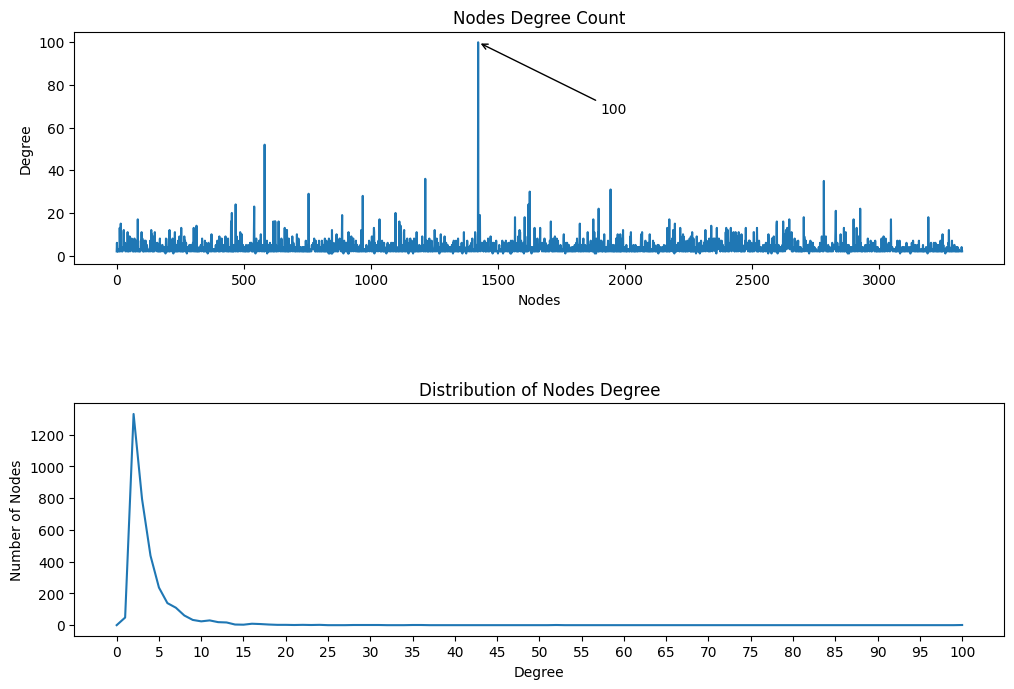

In [14]:
import matplotlib.pyplot as plt

nodes_degrees = torch.bincount(edge_index[0]).numpy()

degree_count = np.zeros(np.max(nodes_degrees) + 1)
for degree in nodes_degrees:
  degree_count[degree] += 1

fig = plt.figure(figsize=(12,8), dpi=100)
fig.subplots_adjust(hspace=0.6)

plt.subplot(211)
plt.plot(nodes_degrees)
plt.annotate(f'{np.max(nodes_degrees)}', xy=(np.where(nodes_degrees==np.max(nodes_degrees))[0][0], np.max(nodes_degrees)), arrowprops = dict(arrowstyle="->"), xytext=(len(nodes_degrees)-np.where(nodes_degrees==np.max(nodes_degrees))[0][0], 2*np.max(nodes_degrees)/3)) # All these calculation is to dynamically assign the position of the text :)
plt.xlabel('Nodes')
plt.ylabel('Degree')
plt.title('Nodes Degree Count')

plt.subplot(212)
plt.plot(degree_count)
plt.xticks(np.arange(0, len(degree_count), 5.0))
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Nodes Degree')


We can see that most nodes have $2-5$ edges (including self-loops) but there is also one outlier with a degree of $100$, this will result in a lot of padding in the model.

## 7. Training and Evaluation
Now we implement the training/validation/test cycle, using Adam as optimizer and CrossEntropy as loss function (Negative Log Likelihood resulted in slightly worse performance).

In [15]:
from sklearn.metrics import f1_score

# Define the model parameters

hidden = 8 # Both the hidden state and lstm features dimension was set to 8 in the paper implementation
lstm_outputs = 8
dropout = 0.5
alpha = 0.2 # 0.2 was used both in the paper of the GAT [Veličković, 2018] from which the GOAT is inspired, and in GOAT
heads_1 = 8
heads_2 = 1
learning_rate = 0.005
decay = 5e-4 # L2 regularization

model = GOATNetwork(features_num, hidden, classes, lstm_outputs, dropout, alpha, heads_1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
lossFunction = torch.nn.CrossEntropyLoss() # CiteSeer

def accuracy(out, labels):
  preds = out.argmax(dim=1)
  correct = preds == labels
  correct = correct.sum()
  return correct / len(labels)


def train():
  ## Train
  model.train()
  optimizer.zero_grad()
  out = model(features, edge_index)
  loss_train = lossFunction(out[graph.train_mask], labels[graph.train_mask])
  acc_train = accuracy(out[graph.train_mask], labels[graph.train_mask])

  loss_train.backward()
  optimizer.step()

  ## Eval (remove dropout for validation)
  model.eval()
  out = model(features, edge_index)
  loss_val = lossFunction(out[graph.val_mask], labels[graph.val_mask])
  acc_val = accuracy(out[graph.val_mask], labels[graph.val_mask])
  f1 = f1_score(out[graph.val_mask].argmax(dim=1), labels[graph.val_mask].detach().numpy(), average='micro')
  return loss_val, acc_val, f1


def test(state_dict=None):
  if state_dict != None:
    model.load_state_dict(state_dict)

  ## Testing (again we remove the dropout)
  model.eval()
  out = model(features, edge_index)
  loss_test = lossFunction(out[graph.test_mask], labels[graph.test_mask])
  acc_test = accuracy(out[graph.test_mask], labels[graph.test_mask])
  print(f'Test set results:\nLoss = {loss_test:.2f}\nAccuracy = {acc_test:.2f}')


We train the model for $100$ epochs, and use early stopping to keep the model with the best accuracy over the validation set:

In [16]:
best_epoch = 0
best = float('inf')
losses = []
accuracies = []
epochs = 100

for epoch in range(epochs):
  loss, acc, f1 = train()
  losses.append(loss.detach())
  accuracies.append(acc.detach())

  # Early Stopping
  if loss < best:
    best = loss
    best_epoch = epoch
    best_state_dict = model.state_dict()

  if epoch % 10 == 0 or epoch == epochs-1:
    print(f'Epoch {epoch:02d}: Loss = {loss:.2f} | Accuracy = {acc:.2f} | F1 Score = {f1:.2f}')
print(f'\nBest Loss = {best:.2f}\n')

test(best_state_dict)

Epoch 00: Loss = 1.78 | Accuracy = 0.19 | F1 Score = 0.19
Epoch 10: Loss = 1.76 | Accuracy = 0.34 | F1 Score = 0.34
Epoch 20: Loss = 1.73 | Accuracy = 0.57 | F1 Score = 0.57
Epoch 30: Loss = 1.65 | Accuracy = 0.70 | F1 Score = 0.70
Epoch 40: Loss = 1.52 | Accuracy = 0.70 | F1 Score = 0.70
Epoch 50: Loss = 1.27 | Accuracy = 0.72 | F1 Score = 0.72
Epoch 60: Loss = 1.09 | Accuracy = 0.69 | F1 Score = 0.69
Epoch 70: Loss = 0.98 | Accuracy = 0.69 | F1 Score = 0.69
Epoch 80: Loss = 0.95 | Accuracy = 0.69 | F1 Score = 0.69
Epoch 90: Loss = 1.00 | Accuracy = 0.67 | F1 Score = 0.67
Epoch 99: Loss = 0.98 | Accuracy = 0.68 | F1 Score = 0.68

Best Loss = 0.95

Test set results:
Loss = 1.01
Accuracy = 0.68


We have got `70%` accuracy on CiteSeer dataset, which is the same result of the paper!

Finally we plot the losses and accuracies to see the convergence of the algorithm:

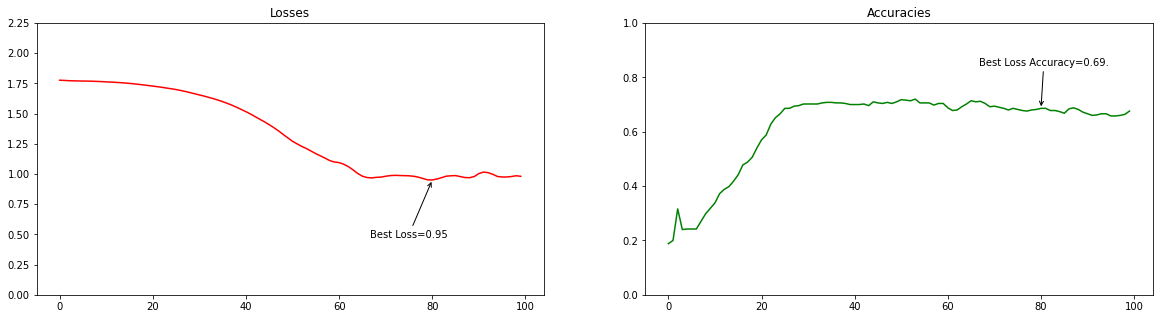

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(losses, c='red')
ax2.plot(accuracies, c='green')
ax1.set_ylim([0, 2.25])
ax2.set_ylim([0, 1])
ax1.set_title("Losses")
ax2.set_title("Accuracies")
ax1.annotate(f'Best Loss={best:.2f}', xy=(best_epoch, best), arrowprops = dict(arrowstyle="->"), xytext=(2*epochs/3, best-best/2))
ax2.annotate(f'Best Loss Accuracy={accuracies[best_epoch]:.2f}.', xy=(best_epoch, accuracies[best_epoch]), arrowprops = dict(arrowstyle="->"), xytext=(2*epochs/3, accuracies[best_epoch]+(1-accuracies[best_epoch])/2))

fig.show()

## 8. Conclusions
The results of the implementation are good but the learning is a little bit slow, optimization could be made to improve the model.<br>
We have trained the model on a single dataset (CiteSeer) which is an example of **transductive learning**, where we use the same graph for training, validation and testing, but for a more thorough analysis of the model we could also test it on different datasets including the ones that allow **inductive learning**, where training, validation and testing is done on different graphs (such as PPI dataset).